In [2]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.vecm import VECM
import matplotlib.pyplot as plt
import warnings
from statsmodels.tools.sm_exceptions import InterpolationWarning
warnings.filterwarnings("ignore", category=InterpolationWarning)

# 1. Transforming Data
We first transform the data into logarithms to stabilise the variance and to be able to interpret differenced variables as approximate growth rates. Since productivity is observed quartelry, we re-sample the wage and CPIH data to be in quarterly frequency to avoid smoothing bias.

In [45]:
df = pd.read_csv('data/preprocessed/quarterly_data.csv')

# Parsing date and setting index
df["Date"] = pd.to_datetime(df["Date"])
df = df.set_index("Date").sort_index()

# Setting as quarter start frequency
df = df.asfreq("QS")

df_log = df.copy()

# Log Transformations
for c in ['CPIH', 'AWE', 'Productivity']:
    if c == 'Productivity':
        df_log['Prod_ln'] = np.log(df_log[c])
    else:
        df_log[f'{c}_ln'] = np.log(df_log[c])

# Creating real wage from wages and productivity
df_log["RealWage_ln"] = df_log["AWE_ln"] - df_log["CPIH_ln"]

display(f"No. of quarterly observations: {df_log.shape[0]}")
display(df_log.head())

'No. of quarterly observations: 101'

,CPIH,AWE,Productivity,CPIH_ln,AWE_ln,Prod_ln,RealWage_ln
Date,,,,,,,
2000-01-01,72.800000,305.320072,82.5,4.287716,5.721361,4.412798,1.433645
2000-04-01,73.466667,310.142558,82.2,4.296832,5.737032,4.409155,1.440200
2000-07-01,73.466667,314.836909,82.7,4.296832,5.752055,4.415220,1.455223
2000-10-01,73.933333,320.155758,82.6,4.303164,5.768808,4.414010,1.465644
2001-01-01,73.700000,324.075836,83.6,4.300003,5.780978,4.426044,1.480975


# 2. Stationarity Tests
We test for stationarity using both the Augmented Dickey-Fuller test and the KPSS test.

## Augmented Dickey Fuller
We test for stationarity firstly on the level variables. We fail to reject the null for the two variables at the 5% level of significance, the series are non-stationary. We then take the first difference of each variables and we reject the null of non-stationarity at even the 1% level of significance. As such the level variables are of order I(1) and the differenced variables are of order I(0).

In [46]:
# Log column list
cols = ['RealWage_ln', 'Prod_ln']

# Running unit root test for each variable
print("Dickey Fuller Test for log variables")
for col in cols:
    adf_test = adfuller(df_log[col], autolag='AIC')[1]
    print(f"{col} : {adf_test}")

#Taking first difference
df_log_diff = df_log[cols].diff().dropna()

#Running unit roots tests for differenced variables
print("\nDickey Fuller Test for log variables - 1st difference")
for col in cols:
    adf_test = adfuller(df_log_diff[col], autolag='AIC')[1]
    print(f"{col} : {adf_test}")

Dickey Fuller Test for log variables
RealWage_ln : 0.13181125796716964
Prod_ln : 0.06482169469104061

Dickey Fuller Test for log variables - 1st difference
RealWage_ln : 1.1752141388911272e-20
Prod_ln : 2.048272406584463e-18


# KPSS test
We test the null of stationarity again, around a constant and around a trend. We strongly reject the null for both trend and level stationarity and conclude that the variables are non-stationary.

In [47]:
# Testing for trend stationarity using KPSS
print("\nKPSS Test for log variables (Stationary Around Constant)")
for col in cols:
    stat, p, lags, crit = kpss(df_log[col].dropna(), regression='c', nlags='auto')
    print(f"{col} KPSS statistic : {stat}")
    print(f"{col} p-value: {p}\n")

print("\nKPSS Test for log variables (Stationary Around Trend)")
for col in cols:
    stat, p, lags, crit = kpss(df_log[col].dropna(), regression='ct', nlags='auto')
    print(f"{col} KPSS statistic : {stat}")
    print(f"{col} p-value: {p}\n")


KPSS Test for log variables (Stationary Around Constant)
RealWage_ln KPSS statistic : 1.0953335016730432
RealWage_ln p-value: 0.01

Prod_ln KPSS statistic : 1.573090325199709
Prod_ln p-value: 0.01


KPSS Test for log variables (Stationary Around Trend)
RealWage_ln KPSS statistic : 0.20366945385283494
RealWage_ln p-value: 0.014623954805186896

Prod_ln KPSS statistic : 0.21659265552362014
Prod_ln p-value: 0.01



# 3. Plotting ACF and PACF
Autocorrelation (ACF) and Partial Autocorrelation (PACF) plots were plotted for each first-differenced variable. This was done to find the appropriate order of lags and differencing.

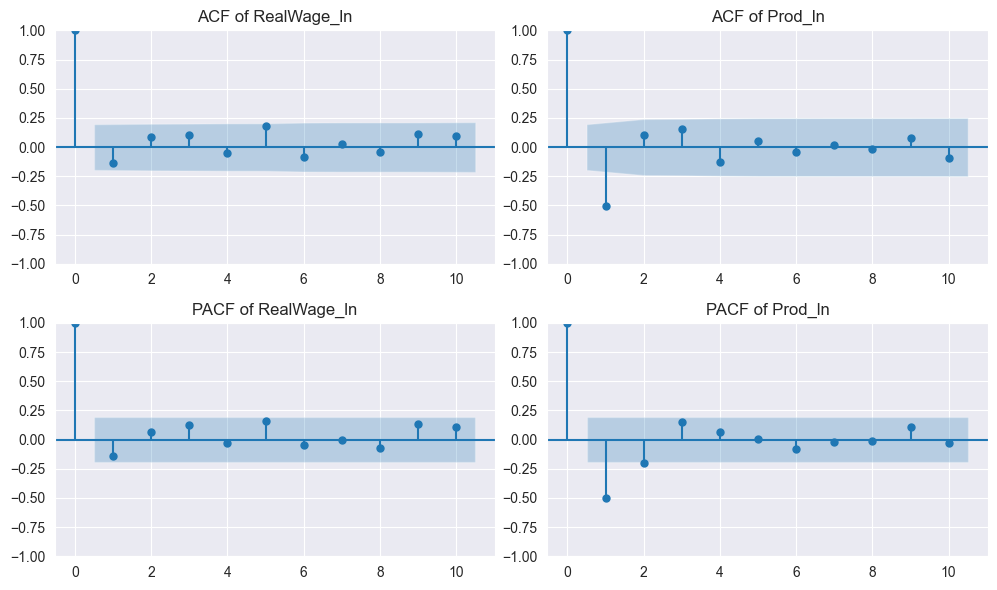

In [48]:
# Setting up plot
fig, axes = plt.subplots(2,2, figsize=(10,6))

for i, col in enumerate(cols):
    # ACF plot with 10 lags - 1st difference
    plot_acf(df_log_diff[col], lags=10, ax=axes[0,i])
    axes[0,i].set_title(f"ACF of {col}")

    # PACF plot with 10 lags
    plot_pacf(df_log_diff[col], lags=10, method="ywm", ax=axes[1,i])
    axes[1,i].set_title(f"PACF of {col}")

plt.tight_layout()
plt.show()


# Interpetation
There is no evidence in the graphs of persistent higher-order autocorrelation so we do not need to take a second difference.

# 4. Lag Order Selection


In [49]:
# Copying df
joh_data = df_log[cols]

# Specifying VAR model
var_model = VAR(joh_data)

# With monthly data we select 12 lags in line with Otero and Smith (1999)
lag_sel = var_model.select_order(maxlags=12)

print(lag_sel.summary())

# Lags selected by AIC and BIC
l_aic = lag_sel.aic
l_bic = lag_sel.bic
print("Selected lag orders:")
print("AIC: ",l_aic)
print("BIC: ",l_bic)

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -14.17      -14.11   7.020e-07      -14.15
1       -17.97      -17.80   1.569e-08      -17.90
2      -18.31*     -18.03*  1.118e-08*     -18.20*
3       -18.29      -17.90   1.139e-08      -18.13
4       -18.25      -17.74   1.193e-08      -18.04
5       -18.16      -17.54   1.302e-08      -17.91
6       -18.13      -17.40   1.342e-08      -17.84
7       -18.10      -17.27   1.381e-08      -17.77
8       -18.03      -17.08   1.496e-08      -17.64
9       -17.98      -16.92   1.573e-08      -17.55
10      -17.92      -16.75   1.678e-08      -17.45
11      -17.88      -16.59   1.760e-08      -17.36
12      -17.89      -16.49   1.755e-08      -17.33
--------------------------------------------------
Selected lag orders:
AIC:  2
BIC:  2


# 5. Cointegration Test
Now that all the variables are stationary of order I(1) we construct a candidate lag set to test for cointegration, a long-term equilibrium relationship between two or more variables. We test using the Johansen trace test with lag order of:
 + $l=2$ - Chosen by AIC and BIC
 + $l=12$ - As per Otero and Smith (2002)

We then compare the trace statistic to the critical values at 1%, 5% and 10% confidence intervals to determine the rank of cointegration.

In [50]:
# Creating list of lag orders -- includes l=12 for
lags = [int(l_aic), 12]

# Converting lag orders to Johansen k_ar_diff
joh_lags = []

for lag in lags:
    joh_lags.append(lag - 1)

print("Candidate lags: ", sorted(joh_lags))

# Running test and iterating over deterministic terms and lag candidates

# det = 0 -> constant   det = 1 -> linear trend
for det in [0,1]:
    print('\nDETERMINISTIC ORDER =', det)
    for lag in sorted(joh_lags):
        joh = coint_johansen(joh_data, det_order=det, k_ar_diff=lag)
        print(f"\nLags: {lag}")
        for r in range(len(cols)):

            # Johansen test trace statistic
            trace = joh.lr1[r]

            cv10  = joh.cvt[r, 0]   # 10% critical value
            cv5   = joh.cvt[r, 1]   # 5% critical value
            cv1   = joh.cvt[r, 2]   # 1% critical value

            rej10 = "Reject" if trace > cv10 else "Fail"
            rej5 = "Reject" if trace > cv5 else "Fail"
            rej1 = "Reject" if trace > cv1 else "Fail"

            display(
                f"H0: r <= {r} | trace = {trace:.3f} | "
                f"cv10 = {cv10:.3f} -> {rej10} | "
                f"cv5  = {cv5: .3f} -> {rej5} | "
                f"cv1  = {cv1: .3f} -> {rej1} | "
            )


Candidate lags:  [1, 11]

DETERMINISTIC ORDER = 0

Lags: 1


'H0: r <= 0 | trace = 11.696 | cv10 = 13.429 -> Fail | cv5  =  15.494 -> Fail | cv1  =  19.935 -> Fail | '

'H0: r <= 1 | trace = 3.938 | cv10 = 2.705 -> Reject | cv5  =  3.841 -> Reject | cv1  =  6.635 -> Fail | '


Lags: 11


'H0: r <= 0 | trace = 14.863 | cv10 = 13.429 -> Reject | cv5  =  15.494 -> Fail | cv1  =  19.935 -> Fail | '

'H0: r <= 1 | trace = 3.543 | cv10 = 2.705 -> Reject | cv5  =  3.841 -> Fail | cv1  =  6.635 -> Fail | '


DETERMINISTIC ORDER = 1

Lags: 1


'H0: r <= 0 | trace = 15.240 | cv10 = 16.162 -> Fail | cv5  =  18.398 -> Fail | cv1  =  23.148 -> Fail | '

'H0: r <= 1 | trace = 4.262 | cv10 = 2.705 -> Reject | cv5  =  3.841 -> Reject | cv1  =  6.635 -> Fail | '


Lags: 11


'H0: r <= 0 | trace = 12.534 | cv10 = 16.162 -> Fail | cv5  =  18.398 -> Fail | cv1  =  23.148 -> Fail | '

'H0: r <= 1 | trace = 3.465 | cv10 = 2.705 -> Reject | cv5  =  3.841 -> Fail | cv1  =  6.635 -> Fail | '

# Interpetation
## Deterministic order 0 (constant)
### Lag = 1
+ $r \leq 0$ -> fail to reject at all levels
+ $r \leq 1$ -> reject at 10% & 5%

What we are interested in is $r \leq 0$ since we only have two variables. At 10% level of signifiance we can reject $r \leq 0$, so there is some evidence of cointegration with a conservative lag specification.

### Lag = 11
+ $r \leq 0$ -> Reject at 10%, 5% but fail to reject at 1%
+ $r \leq 1$ -> reject at 10%


## Deterministic order 1 (trend)
### Lag = 1
+ $r \leq 0$ -> fail to reject at all levels
+ $r \leq 1$ -> reject at 10% & 5%


### Lag = 11
+ $r \leq 0$ -> fail to reject at all levels
+ $r \leq 1$ -> reject at 10%


# Implications for Model Selection
With quarterly data we prefer the results of deterministic order 1, as a trend (intercept) is expected. With both a low lag specification and a high lag specification we fail to reject $r \leq 0$ at all levels of significance. As such we fail to reject the null hypothesis of no cointegration, there is no long-term cointegrating relationship between our variables. Since our variables are I(1) and there is weak evidence of cointegration we will prefer a **VAR in first differences model** over a VECM.

# 6. Model Specification and First Estimate
We will now take the differenced data and select the appropriate lag order to run a VAR(p) model. We calculate the information criteria and prefer the more parsimonious BIC lag specification of **3** lags. As such we fit a VAR(3) model. We are estimating:

## Real Wage Growth Equation
$$ \begin{align}
\Delta RW_t &= \alpha_0
+ \alpha_1 \Delta RW_{t-1}
+ \beta_1 \Delta Prod_{t-1}
+ \varepsilon_{1t}
\end{align} $$

## Productivity Growth Equation
\begin{align}
\Delta Prod_t &= \gamma_0
+ \gamma_1 \Delta RW_{t-1}
+ \delta_1 \Delta Prod_{t-1}
+ \varepsilon_{2t}
\end{align}



In [52]:
# Copying differenced data
var_data = df_log_diff

# Selecting lag length
lag_sel_diff = VAR(var_data).select_order(12)
print(lag_sel_diff.summary())

# Selecting parsimonious BIC specification - 2 lags
p_opt = lag_sel_diff.bic

# Fitting VAR
var_model = VAR(var_data).fit(p_opt)
print(var_model.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -17.91      -17.85   1.670e-08      -17.89
1      -18.30*     -18.13*  1.125e-08*     -18.23*
2       -18.27      -17.99   1.161e-08      -18.16
3       -18.22      -17.82   1.224e-08      -18.06
4       -18.13      -17.63   1.337e-08      -17.93
5       -18.09      -17.47   1.395e-08      -17.84
6       -18.07      -17.34   1.425e-08      -17.78
7       -17.99      -17.15   1.548e-08      -17.65
8       -17.94      -16.98   1.640e-08      -17.55
9       -17.87      -16.80   1.759e-08      -17.44
10      -17.81      -16.63   1.873e-08      -17.34
11      -17.79      -16.49   1.931e-08      -17.27
12      -17.71      -16.30   2.111e-08      -17.14
--------------------------------------------------
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 23, Feb

# VAR Summary Interpetation

## Real Wage Growth Equation
| Variable    | Coefficient |
|-------------|-------------|
| L1.RealWage | -0.183 (*)  |
| L1.Prod_ln  | 0.196 (**)  |

The coefficient on real wage's own lag is negative and we can only reject the null at the 10% level of significance. There is marginal evidence of mean reversion in wage growth i.e. if wages grew last quarter, they'll shrink this quarter.

The coefficient on lagged productivity is significant at the 5% level and we can interpret as a 1% increase in productivity last quarter leading to a 0.196% increase in real wages this quarter. The conclusion from this is that productivity growth translates to much smaller relative real wage growth, consistent with what we observed during out exploratory analysis.

## Productivity Growth Equation
| Variable    | Coefficient  |
|-------------|--------------|
| L1.RealWage | -0.084       |
| L1.Prod_ln  | -0.489 (***) |

The coefficient on the wage term is not significant at even the 10% level and we can conclude that there is weak evidence of wage growth leading to productivity growth. The causality chain points towards productivity growth -> wage growth.

The coefficient on productivity's own lag is highly significant and signals towards strong mean reversion. A productivity shock in t-1 halves in t, so any shock dissipates quickly.

# 7. Residual Diagnostics
We will test the model for residual autocorrelation, stability and normality.

In [53]:
print("-------- Portmanteau Test --------")
print(var_model.test_whiteness(nlags=12), "\n")

print("-------- Stability Test --------")
print("Stable:", var_model.is_stable())
print(var_model.roots, '\n')

print("-------- Normality Test --------")
print(var_model.test_normality())


-------- Portmanteau Test --------
<statsmodels.tsa.vector_ar.hypothesis_test_results.WhitenessTestResults object. H_0: residual autocorrelation up to lag 12 is zero: fail to reject at 5% significance level. Test statistic: 30.857, critical value: 60.481>, p-value: 0.933> 

-------- Stability Test --------
Stable: True
[-3.95985159 -2.37980985] 

-------- Normality Test --------
<statsmodels.tsa.vector_ar.hypothesis_test_results.NormalityTestResults object. H_0: data generated by normally-distributed process: reject at 5% significance level. Test statistic: 223.489, critical value: 9.488>, p-value: 0.000>


# Diagnostics Intepretation
## Portmatneau Test (Residual Autocorrelation)
$ H_0 : \text{No residual autocorrelation up to 12 lags} $

Our p-value is 0.933 so we strongly fail to reject the null, there is no serial correlation in the residuals.

## Stability Test
The test concludes that the model is stable, all roots are well outside the unit circle.

## Normality Test
$ p-value: 0.000 $
We strongly reject the null of normally distributed residuals, our residuals are not normally distributed. This is expected and likely the case of structural breaks e.g. COVID crisis

The key result was serial autocorrelation in the residuals. The model is underspecified, we will need to add more lags

# 9. Impulse Response Functions
Cholesky, ordering, ...

Index(['RealWage_ln', 'Prod_ln'], dtype='object')


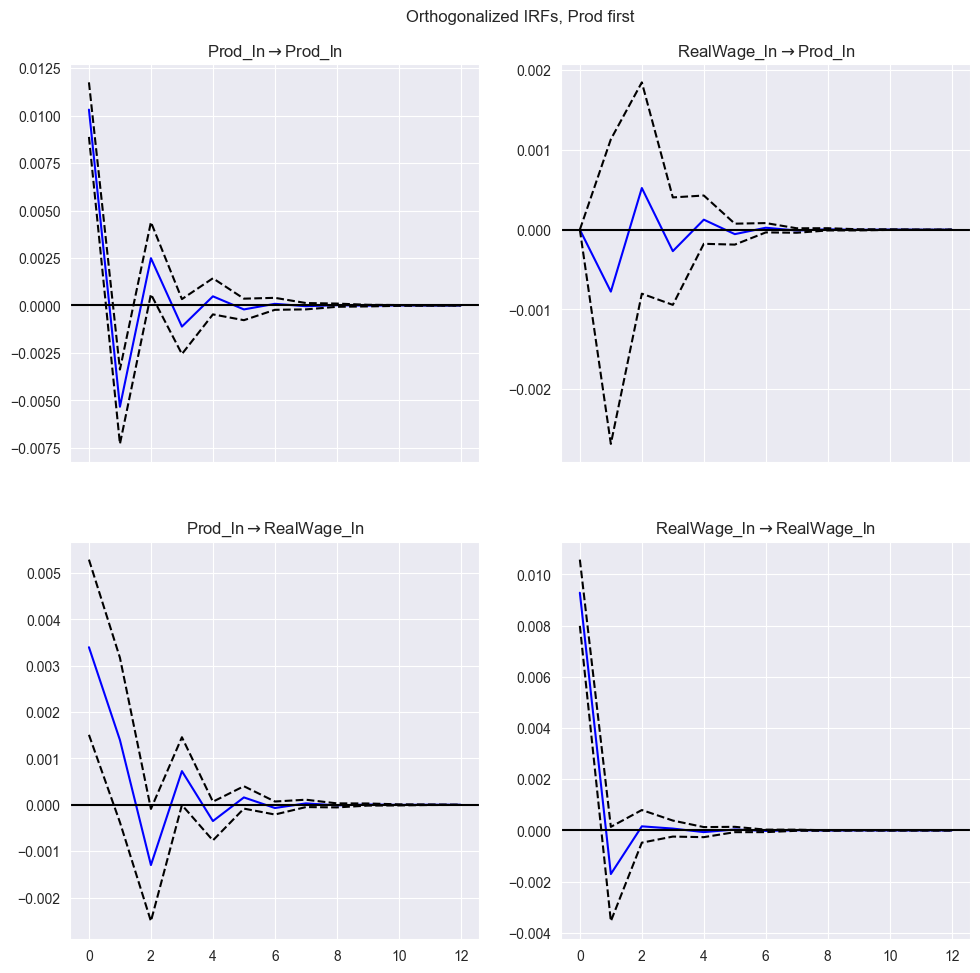

In [57]:
# Displaying ordering of columns
print(var_data.columns)

# Rearranging columns
var_data_ord = var_data[['Prod_ln', 'RealWage_ln']]

# Optimal BIC lags
var_final = VAR(var_data_ord).fit(p_opt)

#Compute IRFs
horizon = 12    # 3 years in quarters
irf = var_final.irf(horizon)

# Plot orthogonalized IRFs (Cholesky)
irf.plot(orth=True)
plt.suptitle(f"Orthogonalized IRFs, Prod first")
plt.show()

# 10. FEVD (Forecast Error Variance Decomposition)

FEVD for Prod_ln
       Prod_ln  RealWage_ln
0     1.000000     0.000000
1     0.995549     0.004451
2     0.993830     0.006170
3     0.993381     0.006619
4     0.993283     0.006717
5     0.993263     0.006737
6     0.993260     0.006740
7     0.993259     0.006741
8     0.993259     0.006741
9     0.993259     0.006741
10    0.993259     0.006741
11    0.993259     0.006741

FEVD for RealWage_ln
       Prod_ln  RealWage_ln
0     0.118118     0.881882
1     0.131543     0.868457
2     0.145582     0.854418
3     0.149874     0.850126
4     0.150864     0.849136
5     0.151066     0.848934
6     0.151105     0.848895
7     0.151112     0.848888
8     0.151114     0.848886
9     0.151114     0.848886
10    0.151114     0.848886
11    0.151114     0.848886


None


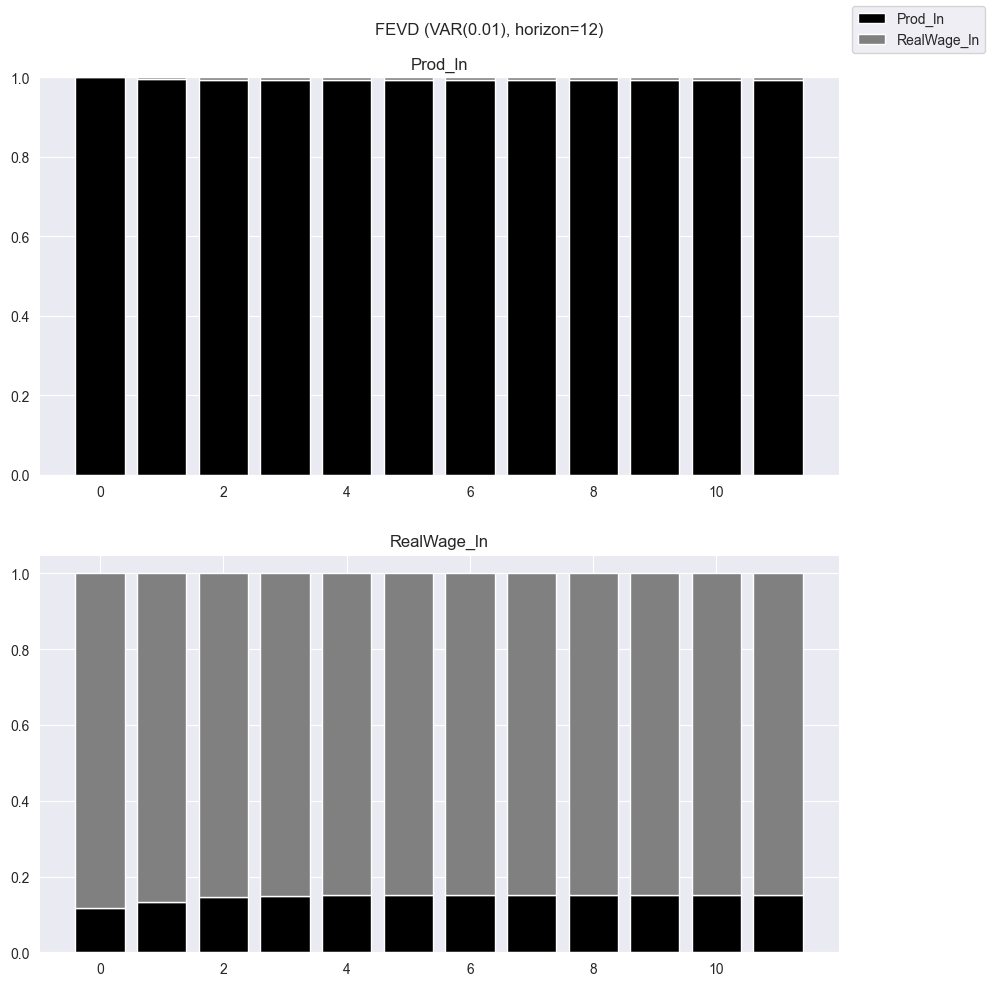

In [58]:
h = 12  # 3 years
fevd = var_final.fevd(h)

print(fevd.summary())

# Plot FEVD
fevd.plot()
plt.suptitle(f"FEVD (VAR({p}), horizon={h})")
plt.show()